# Demo Notebook
This notebook demonstrates the use of the `PyOCN` library to create and optimize Optimal Channel Networks (OCNs) on a grid. It includes functions for generating random OCNs, optimizing them using simulated annealing, and visualizing the results.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import PyOCN as po

## Simple OCN Example

In [2]:
# initialize an OCN from one of the built-in network types with default parameters
ocn = po.OCN.from_net_type(
    net_type="H",
    dims=(50, 50),
    random_state=4000,
    verbosity=2
)

# optimize the OCN using simulated annealing and default parameters
energy_history = ocn.fit()

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 50x50 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 100k/100k [00:01<00:00, 99.3kit/s, Energy=7.29e+3, T=4.54e-14] 


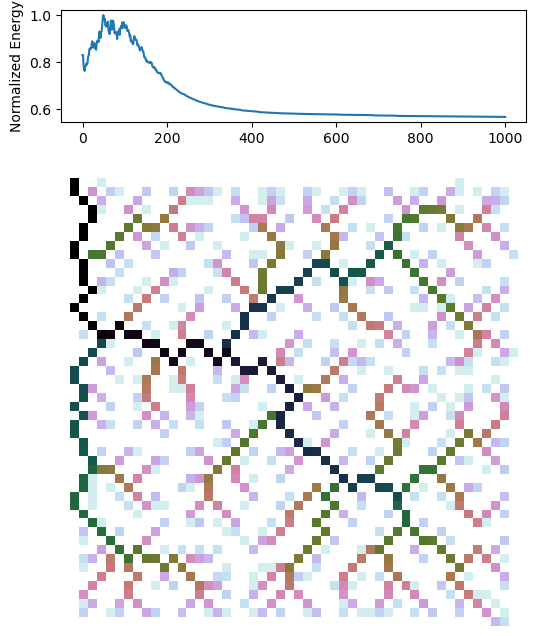

In [3]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(energy_history/np.max(energy_history))
axs[0].set_ylabel("Normalized Energy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[1])
axs[1].set_axis_off()

## Initializing an OCN from a custom DAG

(None, <Axes: >)

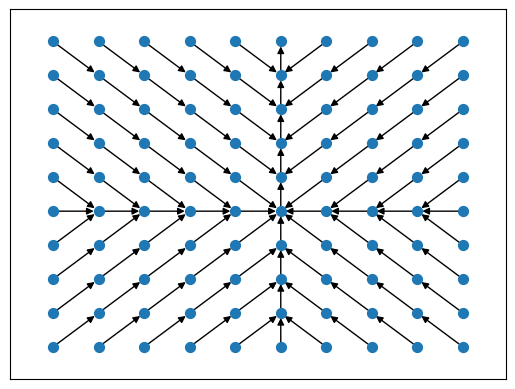

In [4]:
# initialize an OCN from a custom nx.DiGraph instance
from itertools import product

def cross_center_root(m, n):
    dag = nx.DiGraph()
    halfway_r = n // 2
    halfway_u = m // 2
    for i, (r, c) in enumerate(product(range(m), range(n))):
        dag.add_node(i, pos=(r, c))
        
    for i, (r, c) in enumerate(product(range(m), range(n))):
        # ul quadrant
        if r > halfway_u and c < halfway_r:
            dag.add_edge(i, i - n + 1)
        # ur quadrant
        elif r > halfway_u and c > halfway_r:
            dag.add_edge(i, i - n - 1)
        # ll quadrant
        elif r < halfway_u and c < halfway_r:
            dag.add_edge(i, i + n + 1)
        # lr quadrant
        elif r < halfway_u and c > halfway_r:
            dag.add_edge(i, i + n - 1)
        # middle column
        elif c == halfway_r:
            if r > 0:
                dag.add_edge(i, i - n)  # default up
            # if r > halfway_u:
            #     dag.add_edge(i, i - n)
            # elif r < halfway_u:
            #     dag.add_edge(i, i + n)
        # middle row
        else:
            if c > halfway_r:
                dag.add_edge(i, i - 1)
            elif c < halfway_r:
                dag.add_edge(i, i + 1)
    return dag

po.plot_positional_digraph(cross_center_root(10, 10), node_size=50, arrowsize=10, with_labels=False)

In [5]:
m, n = 100, 100
ocn = po.OCN.from_digraph(
    dag=cross_center_root(m, n),
    random_state=4000,
    verbosity=2
)

# optimize the OCN using simulated annealing and default parameters
energy_history = ocn.fit()

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 400k/400k [00:04<00:00, 89.1kit/s, Energy=3.08e+4, T=1.96e-13]


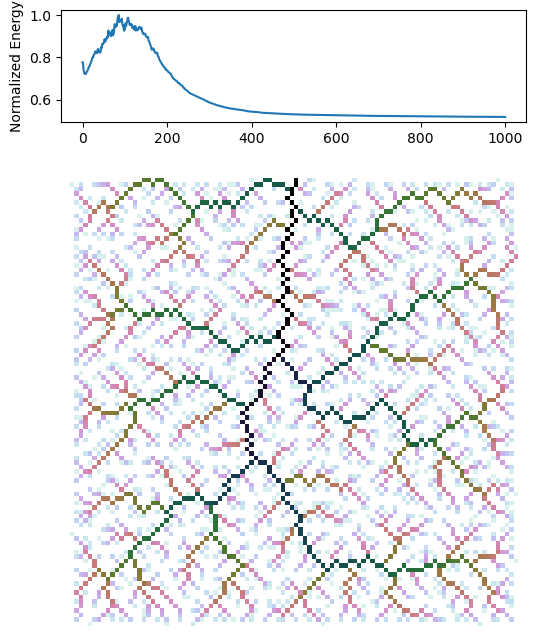

In [6]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(energy_history/np.max(energy_history))
axs[0].set_ylabel("Normalized Energy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[1])
axs[1].set_axis_off()

## Modifying OCN parameters

In [7]:
def ocn_with_params(m, n, gamma, constant_phase, cooling_rate, n_iterations, dag):
    ocn = po.OCN.from_digraph(
        dag=dag,
        gamma=gamma,
        random_state=4000,
        verbosity=2
    )
    # this step is only needed to visualize the cooling schedule. Normally, this is handled internally by ocn.fit.
    cooling_schedule = po.utils.create_cooling_schedule(
        ocn=ocn, 
        constant_phase=constant_phase, 
        n_iterations=n_iterations, 
        cooling_rate=cooling_rate
    )
    energy_history = ocn.fit(
        cooling_rate=cooling_rate,
        constant_phase=constant_phase,
        n_iterations=n_iterations,
    )
    return ocn, energy_history, cooling_schedule

m, n  = 100, 100
dag = cross_center_root(m, n)


## Slow cooling, low gamma (ergotic, dendritic)

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 2.00M/2.00M [00:28<00:00, 71.1kit/s, Energy=1.28e+4, T=7.24e-9] 


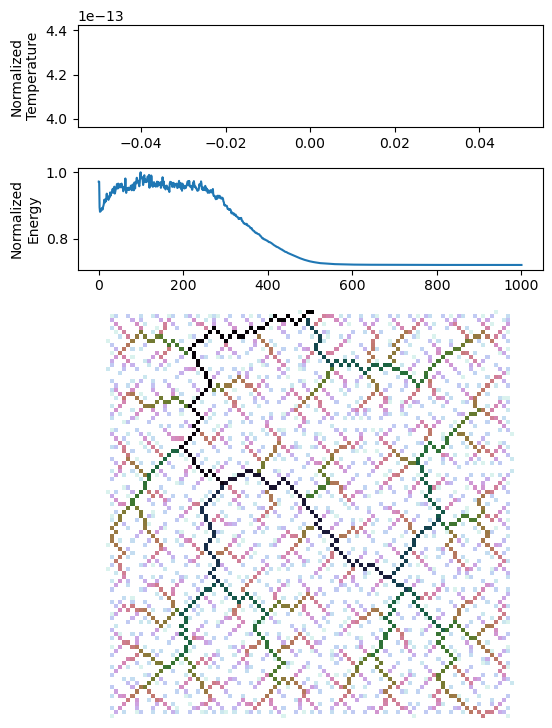

In [ ]:
constant_phase = 0.05
cooling_rate = 0.15
n_iterations = m*n*200
gamma = 0.2
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

## Fast cooling, low gamma (greedy, dendritic)

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 2.00M/2.00M [00:20<00:00, 97.2kit/s, Energy=1.28e+4, T=0]       


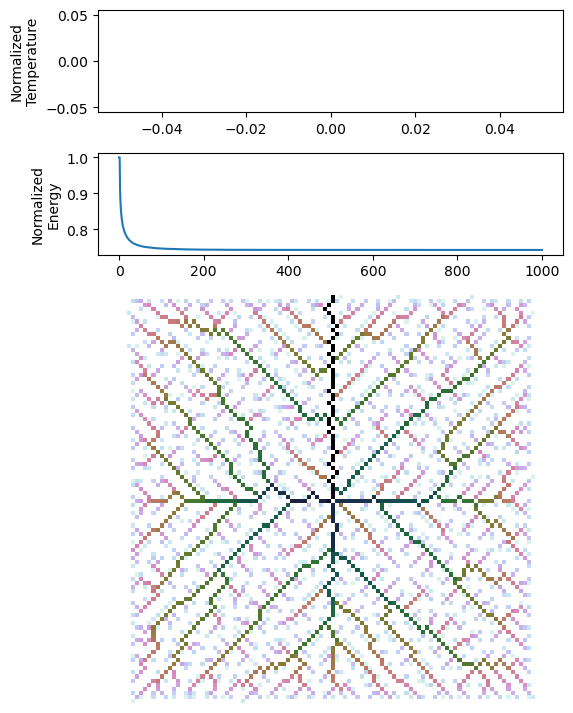

In [ ]:
constant_phase = 0.0
cooling_rate = 100
n_iterations = m*n*200 
gamma = 0.2
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

## Slow cooling, high gamma (ergodic, low-dendricity)

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 2.00M/2.00M [00:19<00:00, 105kit/s, Energy=3.89e+5, T=2.2e-7]  


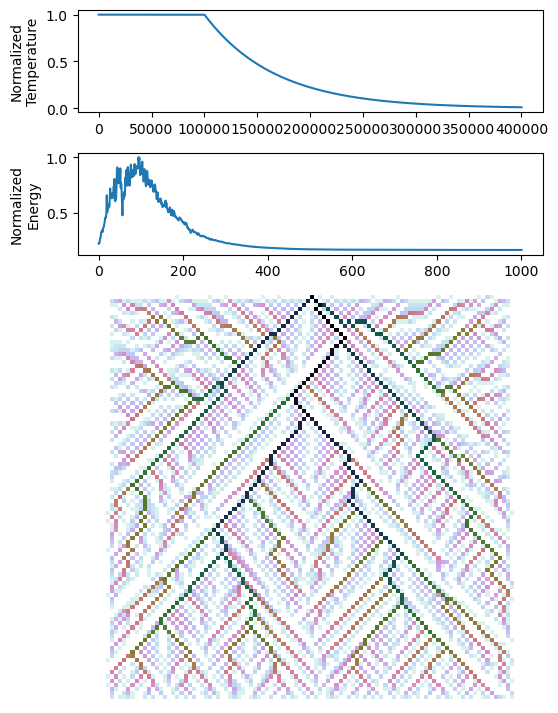

In [ ]:
constant_phase = 0.05
cooling_rate = 0.15
n_iterations = m*n*200
gamma = 0.95
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

## Fast cooling, high gamma (greedy, low-dendricity)

In [ ]:
constant_phase = 0.0
cooling_rate = 100
n_iterations = m*n*200
gamma = 0.95
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

## Some bizarre (non-physical)

/Users/alex/Documents/pet-projects/lang-learn/C/OCN/PyOCN/ocn.py:88: UserWarning: gamma values outside of [0, 1] may not be physically meaningful. Got 2.
  warnings.warn(f"gamma values outside of [0, 1] may not be physically meaningful. Got {gamma}.")


Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 2.00M/2.00M [00:19<00:00, 104kit/s, Energy=2.27e+8, T=3.68e-30]


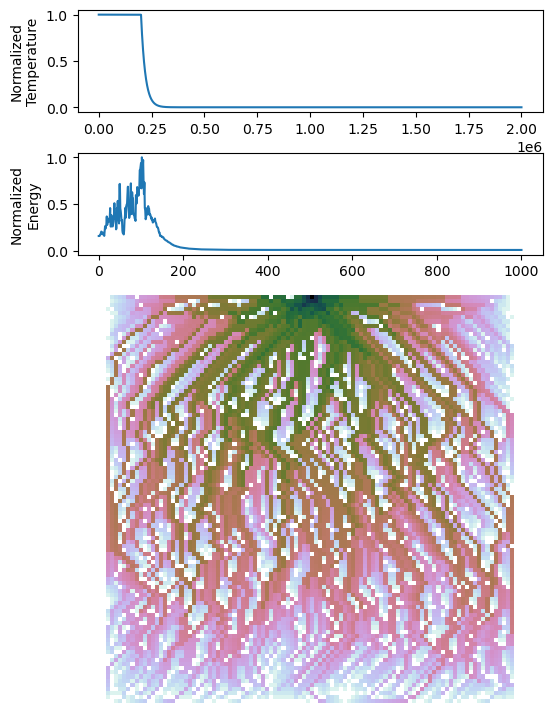

In [14]:
constant_phase = 0.1
cooling_rate = 0.5
n_iterations = m*n*200 
gamma = 2
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='drained_area', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 400k/400k [00:49<00:00, 8.16kit/s, Energy=512, T=2.14e-5]     


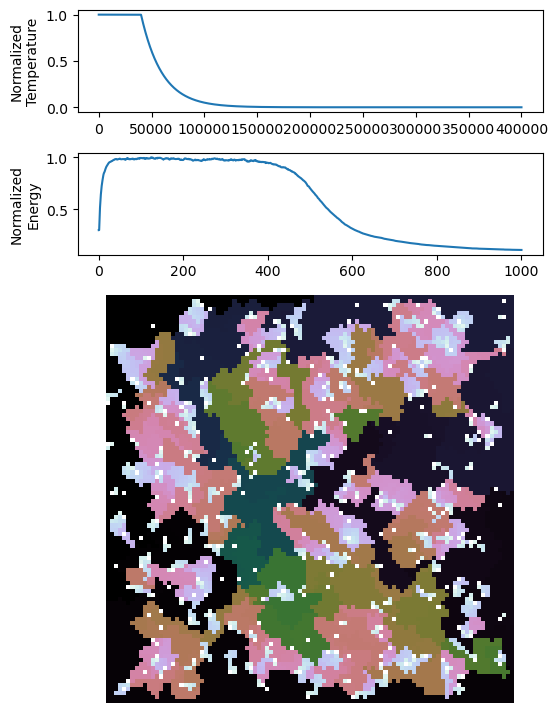

In [13]:
constant_phase = 0.1
cooling_rate = 0.5
n_iterations = m*n*40
gamma = -1
ocn, energy_history, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(energy_history/np.max(energy_history))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()